In [10]:
from __future__ import print_function
import argparse
from math import log10

import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [11]:
from super_resolution.model import Net, BayesianNet
from super_resolution.data import get_training_set, get_test_set

In [12]:
#upscale_factor = 3

class store:
    def __init__(self, up, b, t, n, l, th, se):
        self.upscale_factor = up
        self.batchSize = b
        self.testBatchSize = t
        self.nEpochs = n
        self.lr = l
        self.threads = th
        self.seed = se
        
upscale_factor = 3
batchSize = 4
testBatchSize = 100

#nEpochs = 2
nEpochs = 30
lr = .001

threads = 3
seed = 123
        
opt = store(upscale_factor, batchSize, testBatchSize, nEpochs, lr, threads, seed)


In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

#torch.manual_seed(seed)

In [14]:
print('===> Loading datasets')
train_set = get_training_set(opt.upscale_factor)
test_set = get_test_set(opt.upscale_factor)
training_data_loader = DataLoader(dataset=train_set, num_workers=opt.threads, batch_size=opt.batchSize, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.testBatchSize, shuffle=False)

===> Loading datasets


In [15]:
print('===> Building model')
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}

===> Building model


In [16]:
def train(model, optimizer, criterion, epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        torch.cuda.empty_cache()
        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        kl = 0
        if model.__class__.__name__ == 'BayesianNet':
            output, kl = model(input)
        else:
            output = model(input)
        loss = criterion(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    return epoch, epoch_loss / len(training_data_loader)


def test(model, criterion):
    avg_psnr = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device), batch[1].to(device)

            if model.__class__.__name__ == 'BayesianNet':
                prediction, kl = model(input)
            else:
                prediction = model(input)
            mse = criterion(prediction, target)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
    return avg_psnr / len(testing_data_loader)


def checkpoint(model, epoch, upscale_factor):
    ckpt_dir = f'./super_resolution/models/{model.__class__.__name__}/'
    model_out_path = f"./super_resolution/models/{model.__class__.__name__}/epoch_{epoch}_upscale_factor_{upscale_factor}_device_{str(device).split(':')[0]}.pth"

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)
    
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [17]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

for upscale_factor in [opt.upscale_factor]:
    models = {"Bayesian CNN": BayesianNet(1, upscale_factor, priors).to(device),
        "Classical CNN": Net(upscale_factor=upscale_factor).to(device)
    }
    
    epochs = {name: [] for name in models.keys()}
    epoch_losses = {name: [] for name in models.keys()}
    avg_psnrs = {name: [] for name in models.keys()}
    
    for model_name in models.keys():
        model = models[model_name]
        
        criterion = nn.MSELoss()

        optimizer = optim.Adam(model.parameters(), lr=opt.lr)
        
        for epoch in range(1, opt.nEpochs + 1):
            # TODO: for stats see train.py
            epoch, epoch_loss = train(model, optimizer, criterion, epoch)
            avg_psnr = test(model, criterion)
            checkpoint(model, epoch, upscale_factor)

            epochs[model_name].append(epoch)
            epoch_losses[model_name].append(epoch_loss)
            avg_psnrs[model_name].append(avg_psnr)

===> Epoch[1](1/50): Loss: 6.0254
===> Epoch[1](2/50): Loss: 1.9559
===> Epoch[1](3/50): Loss: 2.2168
===> Epoch[1](4/50): Loss: 2.5051
===> Epoch[1](5/50): Loss: 0.9869
===> Epoch[1](6/50): Loss: 0.9981
===> Epoch[1](7/50): Loss: 1.2246
===> Epoch[1](8/50): Loss: 0.7878
===> Epoch[1](9/50): Loss: 0.9793
===> Epoch[1](10/50): Loss: 0.4218
===> Epoch[1](11/50): Loss: 0.3243
===> Epoch[1](12/50): Loss: 0.3581
===> Epoch[1](13/50): Loss: 0.4560
===> Epoch[1](14/50): Loss: 0.5850
===> Epoch[1](15/50): Loss: 0.4478
===> Epoch[1](16/50): Loss: 0.3906
===> Epoch[1](17/50): Loss: 0.6764
===> Epoch[1](18/50): Loss: 0.3462
===> Epoch[1](19/50): Loss: 0.3659
===> Epoch[1](20/50): Loss: 0.2036
===> Epoch[1](21/50): Loss: 0.1942
===> Epoch[1](22/50): Loss: 0.2025
===> Epoch[1](23/50): Loss: 0.3076
===> Epoch[1](24/50): Loss: 0.3264
===> Epoch[1](25/50): Loss: 0.2449
===> Epoch[1](26/50): Loss: 0.2411
===> Epoch[1](27/50): Loss: 0.2699
===> Epoch[1](28/50): Loss: 0.2194
===> Epoch[1](29/50): Loss: 0

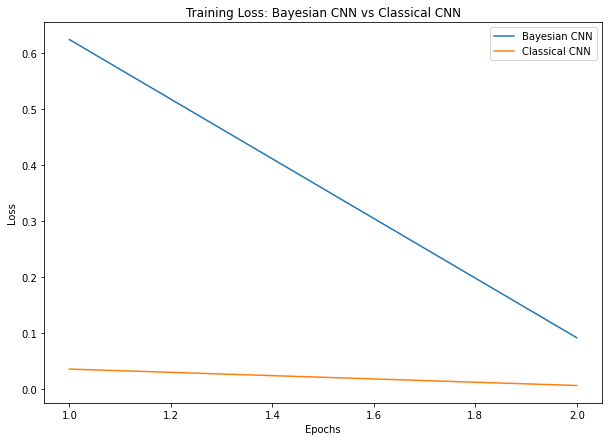

In [9]:
# loss plots
plt.figure(figsize=(10, 7))
plt.title(f"Training Loss: Bayesian CNN vs Classical CNN")

for model_name in epochs:
    plt.plot(epochs[model_name], epoch_losses[model_name], label=model_name)
# plt.plot(val_loss, color='red', label='validataion loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.savefig(f'./graphs/loss_model_{model.__class__.__name__}_epochs_{opt.nEpochs}_upscale_factor_{upscale_factor}.png')

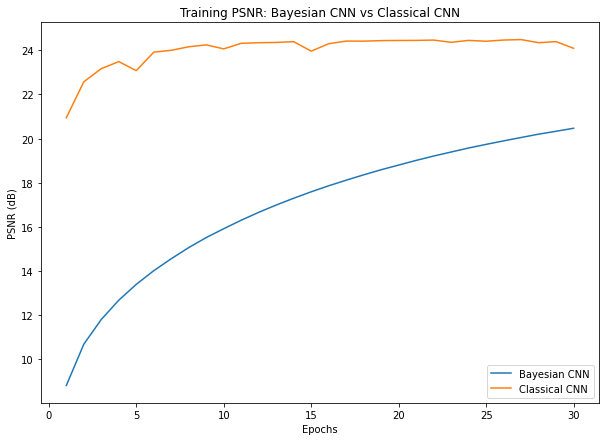

In [44]:
# loss plots
plt.figure(figsize=(10, 7))
plt.title(f"Training PSNR: Bayesian CNN vs Classical CNN")

for model_name in epochs:
    plt.plot(epochs[model_name], avg_psnrs[model_name], label=model_name)

# plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()    
